### Quick Start

The `LANfactory` package is a light-weight convenience package for training `likelihood approximation networks` (LANs) in torch (or keras), 
starting from supplied training data.

[LANs](https://elifesciences.org/articles/65074), although more general in potential scope of applications, were conceived in the context of sequential sampling modeling
to account for cognitive processes giving rise to *choice* and *reaction time* data in *n-alternative forced choice experiments* commonly encountered in the cognitive sciences.

In this quick tutorial we will use the [`ssms`](https://github.com/AlexanderFengler/ssm_simulators) package to generate our training data using such a sequential sampling model (SSM). The use of of the `LANfactory` package is in no way bound to utilize this `ssms` package.

#### Install

To install the `ssms` package type,

`pip install git+https://github.com/AlexanderFengler/ssm_simulators`

To install the `LANfactory` package type,

`pip install git+https://github.com/AlexanderFengler/LANfactory`

Necessary dependency should be installed automatically in the process.

#### Basic Tutorial

In [1]:
# Load necessary packages
import ssms
import lanfactory
import os
import numpy as np
from copy import deepcopy
import torch

wandb not available
wandb not available


#### Generate Training Data
First we need to generate some training data. As mentioned above we will do so using the `ssms` python package, however without delving into a detailed explanation
of this package. Please refer to the [basic ssms tutorial] (https://github.com/AlexanderFengler/ssm_simulators) in case you want to learn more.

In [2]:
# MAKE CONFIGS
model = "angle"
# Initialize the generator config (for MLP LANs)
generator_config = deepcopy(ssms.config.data_generator_config["lan"])
# Specify generative model (one from the list of included models mentioned above)
generator_config["model"] = model
# Specify number of parameter sets to simulate
generator_config["n_parameter_sets"] = 100
# Specify how many samples a simulation run should entail
generator_config["n_samples"] = 1000
# Specify folder in which to save generated data
generator_config["output_folder"] = "data/lan_mlp/" + model + "/"

# Make model config dict
model_config = ssms.config.model_config[model]

In [3]:
# MAKE DATA

my_dataset_generator = ssms.dataset_generators.lan_mlp.data_generator(
    generator_config=generator_config, model_config=model_config
)

training_data = my_dataset_generator.generate_data_training_uniform(save=True)

n_cpus used:  12
checking:  data/lan_mlp/angle/
simulation round: 1  of 10
simulation round: 2  of 10
simulation round: 3  of 10
simulation round: 4  of 10
simulation round: 5  of 10
simulation round: 6  of 10
simulation round: 7  of 10
simulation round: 8  of 10
simulation round: 9  of 10
simulation round: 10  of 10
Writing to file:  data/lan_mlp/angle//training_data_6c3d3918ae0611efaf8d6ae25f443f63.pickle


In [4]:
# training_data

#### Prepare for Training

Next we set up dataloaders for training with pytorch. The `LANfactory` uses custom dataloaders, taking into account particularities of the expected training data.
Specifically, we expect to receive a bunch of training data files (the present example generates only one), where each file hosts a large number of training examples. 
So we want to define a dataloader which spits out batches from data with a specific training data file, and keeps checking when to load in a new file. 
The way this is implemented here, is via the `DatasetTorch` class in `lanfactory.trainers`, which inherits from `torch.utils.data.Dataset` and prespecifies a `batch_size`. Finally this is supplied to a [`DataLoader`](https://pytorch.org/docs/stable/data.html), for which we keep the `batch_size` argument at 0.

The `DatasetTorch` class is then called as an iterator via the DataLoader and takes care of batching as well as file loading internally. 

You may choose your own way of defining the `DataLoader` classes, downstream you are simply expected to supply one.

In [5]:
# MAKE DATALOADERS

# List of datafiles (here only one)
folder_ = "data/lan_mlp/" + model + "/"  # + "/training_data_0_nbins_0_n_1000/"
file_list_ = [folder_ + file_ for file_ in os.listdir(folder_)]

# Training dataset
torch_training_dataset = lanfactory.trainers.DatasetTorch(
    file_ids=file_list_,
    batch_size=128,
    features_key="lan_data",
    label_key="lan_labels",
)

torch_training_dataloader = torch.utils.data.DataLoader(
    torch_training_dataset,
    shuffle=True,
    batch_size=None,
    num_workers=1,
    pin_memory=True,
)

# Validation dataset
torch_validation_dataset = lanfactory.trainers.DatasetTorch(
    file_ids=file_list_,
    batch_size=128,
    features_key="lan_data",
    label_key="lan_labels",
)

torch_validation_dataloader = torch.utils.data.DataLoader(
    torch_validation_dataset,
    shuffle=True,
    batch_size=None,
    num_workers=1,
    pin_memory=True,
)

Now we define two configuration dictionariers,

1. The `network_config` dictionary defines the architecture and properties of the network
2. The `train_config` dictionary defines properties concerning training hyperparameters

Two examples (which we take as provided by the package, but which you can adjust according to your needs) are provided below.

In [6]:
# SPECIFY NETWORK CONFIGS AND TRAINING CONFIGS

network_config = lanfactory.config.network_configs.network_config_mlp

print("Network config: ")
print(network_config)

train_config = lanfactory.config.network_configs.train_config_mlp

print("Train config: ")
print(train_config)

Network config: 
{'layer_sizes': [100, 100, 1], 'activations': ['tanh', 'tanh', 'linear'], 'train_output_type': 'logprob'}
Train config: 
{'cpu_batch_size': 128, 'gpu_batch_size': 256, 'n_epochs': 5, 'optimizer': 'adam', 'learning_rate': 0.002, 'lr_scheduler': 'reduce_on_plateau', 'lr_scheduler_params': {}, 'weight_decay': 0.0, 'loss': 'huber', 'save_history': True}


We can now load a network, and save the configuration files for convenience.

In [7]:
# LOAD NETWORK
net = lanfactory.trainers.TorchMLP(
    network_config=deepcopy(network_config),
    input_shape=torch_training_dataset.input_dim,
    save_folder="/data/torch_models/",
    generative_model_id="angle",
)

# SAVE CONFIGS
lanfactory.utils.save_configs(
    model_id="angle" + "_torch_",
    save_folder="data/torch_models/angle/",
    network_config=network_config,
    train_config=train_config,
    allow_abs_path_folder_generation=True,
)

Setting network type to "lan" or "cpn" based on train_output_type. 
Note: This is only a default setting, and can be overwritten by the network_type argument.
tanh
tanh
linear
Found folder:  data
Moving on...
Found folder:  data/torch_models
Moving on...
Found folder:  data/torch_models/angle
Moving on...
Saved network config
Saved train config


To finally train the network we supply our network, the dataloaders and training config to the `ModelTrainerTorchMLP` class, from `lanfactory.trainers`.

In [8]:
# TRAIN MODEL
model_trainer = lanfactory.trainers.ModelTrainerTorchMLP(
    model=net,
    train_config=train_config,
    train_dl=torch_training_dataloader,
    valid_dl=torch_validation_dataloader,
    allow_abs_path_folder_generation=False,
    pin_memory=True,
    seed=None,
)

# model_trainer.train_model(save_history=True, save_model=True, verbose=0)
model_trainer.train_and_evaluate()
# LOAD MODEL

Torch Device:  cpu
train_config is passed as dictionary: 
{'cpu_batch_size': 128, 'gpu_batch_size': 256, 'n_epochs': 5, 'optimizer': 'adam', 'learning_rate': 0.002, 'lr_scheduler': 'reduce_on_plateau', 'lr_scheduler_params': {}, 'weight_decay': 0.0, 'loss': 'huber', 'save_history': True}
{'cpu_batch_size': 128, 'gpu_batch_size': 256, 'n_epochs': 5, 'optimizer': 'adam', 'learning_rate': 0.002, 'lr_scheduler': 'reduce_on_plateau', 'lr_scheduler_params': {}, 'weight_decay': 0.0, 'loss': 'huber', 'save_history': True}
Found folder:  data
Moving on...
name 'wandb' is not defined
wandb not available, not storing results there
passing 4
name 'wandb' is not defined


/Users/afengler/miniconda3/envs/lanfactory/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


wandb not available
wandb not available
epoch: 0 / 5, batch: 0 / 6248, batch_loss: 18.424171447753906
epoch: 0 / 5, batch: 100 / 6248, batch_loss: 26.35689926147461
epoch: 0 / 5, batch: 200 / 6248, batch_loss: 21.270301818847656
epoch: 0 / 5, batch: 300 / 6248, batch_loss: 41.69943618774414
epoch: 0 / 5, batch: 400 / 6248, batch_loss: 12.145707130432129
epoch: 0 / 5, batch: 500 / 6248, batch_loss: 7.219738006591797
epoch: 0 / 5, batch: 600 / 6248, batch_loss: 14.006623268127441
epoch: 0 / 5, batch: 700 / 6248, batch_loss: 13.515326499938965
epoch: 0 / 5, batch: 800 / 6248, batch_loss: 17.281633377075195
epoch: 0 / 5, batch: 900 / 6248, batch_loss: 7.4594902992248535
epoch: 0 / 5, batch: 1000 / 6248, batch_loss: 20.00450897216797
epoch: 0 / 5, batch: 1100 / 6248, batch_loss: 7.115589141845703
epoch: 0 / 5, batch: 1200 / 6248, batch_loss: 6.586312770843506
epoch: 0 / 5, batch: 1300 / 6248, batch_loss: 8.359161376953125
epoch: 0 / 5, batch: 1400 / 6248, batch_loss: 10.252017974853516
epoc

#### Load Model for Inference and Call

The `LANfactory` provides some convenience functions to use networks for inference after training. 
We can load a model using the `LoadTorchMLPInfer` class, which then allows us to run fast inference via either
a direct call, which expects a `torch.tensor` as input, or the `predict_on_batch` method, which expects a `numpy.array` 
of `dtype`, `np.float32`. 

In [9]:
network_path_list = os.listdir("data/torch_models/angle/")
network_file_path = [
    "data/torch_models/angle/" + file_
    for file_ in network_path_list
    if "state_dict" in file_
][0]

network = lanfactory.trainers.LoadTorchMLPInfer(
    model_file_path=network_file_path,
    network_config=network_config,
    input_dim=torch_training_dataset.input_dim,
)

Setting network type to "lan" or "cpn" based on train_output_type. 
Note: This is only a default setting, and can be overwritten by the network_type argument.
tanh
tanh
linear


/Users/afengler/Library/CloudStorage/OneDrive-Personal/project_lanfactory/LANfactory/lanfactory/trainers/torch_mlp.py:704: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self

In [10]:
# Two ways to call the network

# Direct call --> need tensor input
direct_out = network(
    torch.from_numpy(np.array([1, 1.5, 0.5, 1.0, 0.1, 0.65, 1], dtype=np.float32))
)
print("direct call out: ", direct_out)

# predict_on_batch method
predict_on_batch_out = network.predict_on_batch(
    np.array([1, 1.5, 0.5, 1.0, 0.1, 0.65, 1], dtype=np.float32)
)
print("predict_on_batch out: ", predict_on_batch_out)

direct call out:  tensor([-66.0045])
predict_on_batch out:  [-66.00449]


#### A peek into the first passage distribution computed by the network

We can compare the learned likelihood function in our `network` with simulation data from the underlying generative model.
For this purpose we recruit the [`ssms`](https://github.com/AlexanderFengler/ssm_simulators) package again.

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.DataFrame(
    np.zeros((2000, 7), dtype=np.float32),
    columns=["v", "a", "z", "t", "theta", "rt", "choice"],
)
data["v"] = 0.5
data["a"] = 0.75
data["z"] = 0.5
data["t"] = 0.2
data["theta"] = 0.1
data.loc[np.arange(0, 1000), "rt"] = np.linspace(5, 0, 1000).astype(np.float32)
data.loc[np.arange(1000, 2000), "rt"] = np.linspace(0, 5, 1000).astype(np.float32)
data.loc[np.arange(0, 1000), "choice"] = -1
data.loc[np.arange(1000, 2000), "choice"] = 1

# Network predictions
predict_on_batch_out = network.predict_on_batch(data.values.astype(np.float32))

# Simulations
from ssms.basic_simulators.simulator import simulator

sim_out = simulator(model="angle", theta=data.values[0, :-2], n_samples=2000)

Text(0, 0.5, 'likelihod')

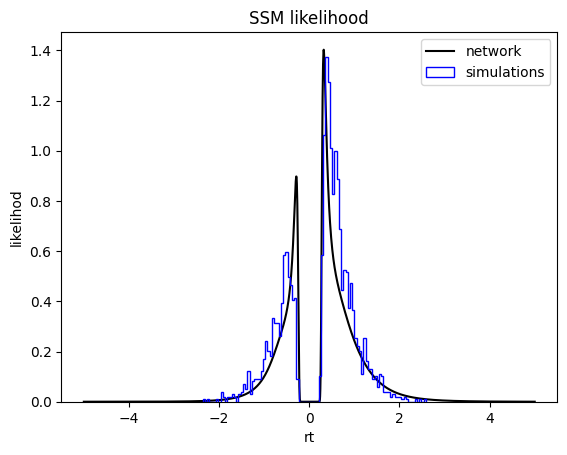

In [56]:
# Plot network predictions
plt.plot(
    data["rt"] * data["choice"],
    np.exp(predict_on_batch_out),
    color="black",
    label="network",
)

# Plot simulations
plt.hist(
    sim_out["rts"] * sim_out["choices"],
    bins=100,
    histtype="step",
    label="simulations",
    color="blue",
    density=True,
)
plt.legend()
plt.title("SSM likelihood")
plt.xlabel("rt")
plt.ylabel("likelihod")

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.DataFrame(
    np.zeros((2000, 7), dtype=np.float32),
    columns=["v", "a", "z", "t", "theta", "rt", "choice"],
)
data["v"] = 0.5
data["a"] = 0.75
data["z"] = 0.5
data["t"] = 0.2
data["theta"] = 0.1
data.loc[np.arange(0, 1000), "rt"] = np.linspace(20, 0, 1000).astype(np.float32)
data.loc[np.arange(1000, 2000), "rt"] = np.linspace(0, 20, 1000).astype(np.float32)
data.loc[np.arange(0, 1000), "choice"] = -1
data.loc[np.arange(1000, 2000), "choice"] = 1

# Network predictions
predict_on_batch_out = network.predict_on_batch(data.values.astype(np.float32))

# Simulations
from ssms.basic_simulators.simulator import simulator

sim_out = simulator(model="angle", theta=data.values[0, :-2], n_samples=2000)

Text(0, 0.5, 'logl')

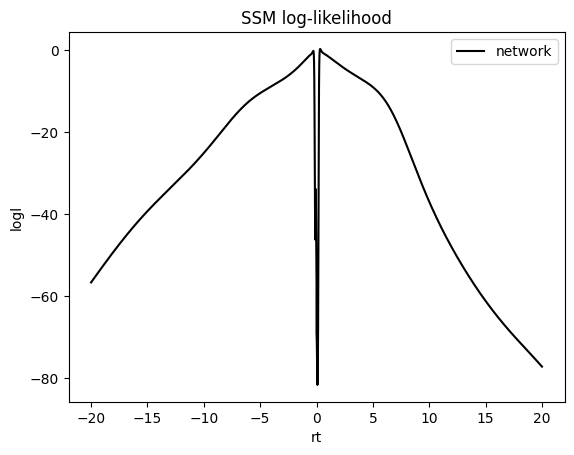

In [59]:
# Plot network predictions
plt.plot(
    data["rt"] * data["choice"],
    predict_on_batch_out,
    color="black",
    label="network",
)

plt.legend()
plt.title("SSM log-likelihood")
plt.xlabel("rt")
plt.ylabel("logl")

We hope this package may be helpful in case you attempt to train [LANs](https://elifesciences.org/articles/65074) for your own research.

#### END